# Cube analysis with Gammapy

## Introduction 
In order to run a 3D analysis (spectral+morphology), you have to construct the counts cube, the bkg cube, the exposure cube, a mean PSF cube and a mean RMF.

This tutorial shows:
- How to compute the counts, the bkg, the exposure, the excess and the significance cube.

    It will use:
        
    [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the data to stack in the cube
 
    [gammapy.image.SkyMask](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyMask.html) for computing the BKG model 

    [gammapy.cube.SkyCube](http://docs.gammapy.org/en/latest/api/gammapy.cube.SkyCube.html) and [gammapy.cube.StackedObsCubeMaker](http://docs.gammapy.org/en/latest/api/gammapy.cube.StackedObsCubeMaker.html) to stack the data in the Cube

- How to compute the mean PSF cube and mean rmf for a set of runs used in the 3D analysis

  It will use the method in [gammapy.data.ObservationList](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationList.html) to make the computation of the mean PSF and mean RMF of a set of runs
 



In [19]:
## Import

In [20]:
import numpy as np
import os
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore, ObservationList
from gammapy.image import SkyMask
from gammapy.cube import SkyCube, StackedObsCubeMaker
from gammapy.utils.energy import Energy, EnergyBounds
from gammapy.irf import TablePSF
from astropy.units import Quantity
from gammapy.background import fill_acceptance_image
from gammapy.extern.pathlib import Path



## Define a method to create empty SkyCube

In [21]:
def make_empty_cube(image_size, energy, center, data_unit=None):
    """
    Parameters
    ----------
    image_size:int, Total number of pixel of the 2D map
    energy: Tuple for the energy axis: (Emin,Emax,nbins)
    center: SkyCoord of the source
    unit : str, Data unit.
    """
    def_image = dict()
    def_image["nxpix"] = image_size
    def_image["nypix"] = image_size
    def_image["binsz"] = 0.02
    def_image["xref"] = center.galactic.l.deg
    def_image["yref"] = center.galactic.b.deg
    def_image["proj"] = 'TAN'
    def_image["coordsys"] = 'GAL'
    def_image["unit"] = data_unit
    e_min, e_max, nbins = energy
    empty_cube = SkyCube.empty(emin=e_min.value, emax=e_max.value, enumbins=nbins, eunit=e_min.unit, mode='edges',
                               **def_image)
    return empty_cube


## Compute Cubes assuming that the resonctructed energy is the same than the true energy

### Compute Counts, background, significance, excess and exposure Cube

Load the Data we will stack in the cube. Here we take the data from gammapy-extra with the 4 crab runs in which the hdu_table contains a link to a background model.

You can for example take the dataset directory we juste created with the background_model.ipynb notebook with a hdu table that has a link for each run to the background models we just created with this notebook. You just have to replace the dataset_directory by cwd+"/data".

In [22]:
#data_store containing the observations you will stack in the cube
dataset_directory="$GAMMAPY_EXTRA/test_datasets/cube/data"
#cwd=os.getcwd()
#dataset_directory=cwd+"/data"
data_store = DataStore.from_dir(dataset_directory)

You define the Cube in which you want to stack the data: center, (x,y) pixels and energy bins

In [23]:
ereco = [Energy(0.5, "TeV"), Energy(40, "TeV"), 5]
etrue = ereco

center = SkyCoord(83.63, 22.01, unit='deg').galactic

#Cube to store the data, here ereco=etrue so this is the same for the counts, the bkg or the exposure
ref_cube_images = make_empty_cube(image_size=50, energy=ereco, center=center)
ref_cube_exposure = make_empty_cube(image_size=50, energy=etrue, center=center, data_unit="m2 s")

You define an exclusion mask that will be use to create the backgroud 2D map. The background map are normalized on the counts map outside the exclusion region

In [24]:
#Exclusion mask that will be use to normalise each of the bkg images for each observation with the counts cube outside the exclusion region
refheader = ref_cube_images.sky_image_ref.to_image_hdu().header
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')
exclusion_mask = exclusion_mask.reproject(reference=refheader)

Make and write the Cubes

In [25]:
# Pb with the load psftable for one of the run that is not implemented yet...
data_store.hdu_table.remove_row(14)
#Select the offset band on which you want to select the events in the FOV of each observation
offset_band = Angle([0, 2.49], 'deg')
cube_maker = StackedObsCubeMaker(empty_cube_images=ref_cube_images, empty_exposure_cube=ref_cube_exposure,
                                 offset_band=offset_band, data_store=data_store, obs_table=data_store.obs_table,
                                 exclusion_mask=exclusion_mask, save_bkg_scale=True)
cube_maker.make_cubes(make_background_image=True, radius=10.)

filename_mask = 'exclusion_mask.fits'
filename_counts = 'counts_cube.fits'
filename_bkg = 'bkg_cube.fits'
filename_significance = 'significance_cube.fits'
filename_excess = 'excess_cube.fits'
filename_exposure = 'exposure_cube.fits'
exclusion_mask.write(filename_mask, clobber=True)
cube_maker.counts_cube.write(filename_counts, format="fermi-counts", clobber=True)
cube_maker.bkg_cube.write(filename_bkg, format="fermi-counts", clobber=True)
cube_maker.significance_cube.write(filename_significance, format="fermi-counts", clobber=True)
cube_maker.excess_cube.write(filename_excess, format="fermi-counts", clobber=True)
cube_maker.exposure_cube.write(filename_exposure, format="fermi-counts", clobber=True)

### Counts and background plots

In [26]:
energies=cube_maker.counts_cube.energies(mode="edges")
print("the bin edges of the count cubes ", energies)
print("")

('the bin edges of the count cubes ', <Quantity [  0.5       ,  1.20112443,  2.88539981,  6.93144843,
            16.65106415, 40.        ] TeV>)



Counts image in the energy band: 0.50-1.20 TeV


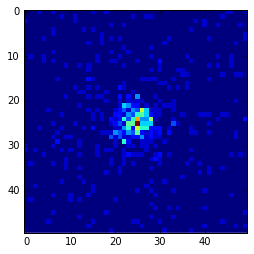

In [27]:
import pylab as plt
plt.ion()
print("Counts image in the energy band: "+str("%.2f"%energies[0].value)+"-"+str("%.2f"%energies[1].value)+" TeV")
plt.figure()
plt.imshow(cube_maker.counts_cube.data[0,:,:],interpolation='None')
#plt.pcolor(cube_maker.counts_cube.data[0,:,:])

Counts image in the energy band: 6.93-16.65 TeV


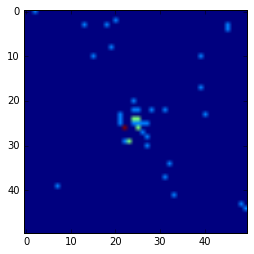

In [28]:
print("Counts image in the energy band: "+str("%.2f"%energies[3].value)+"-"+str("%.2f"%energies[4].value)+" TeV")
plt.figure()
plt.imshow(cube_maker.counts_cube.data[3,:,:])

Bkg image in the energy band: 0.50-1.20 TeV


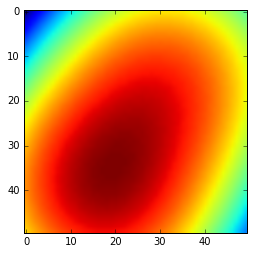

In [29]:
print("Bkg image in the energy band: "+str("%.2f"%energies[0].value)+"-"+str("%.2f"%energies[1].value)+" TeV")
plt.figure()
plt.imshow(cube_maker.bkg_cube.data[0,:,:])

### Build a mean psf cube from a list of observation

In [30]:
#Define a method for the mean psf from a list of obervsation
def make_mean_psf_cube(image_size, energy_cube, center_maps, center, ObsList,
                       spectral_index=2.3):
    """
    Compute the mean psf for a set of observation for different energy bands
    Parameters
    ----------
    image_size:int, Total number of pixel of the 2D map
    energy: Tuple for the energy axis: (Emin,Emax,nbins)
    center_maps: SkyCoord
            center of the images
    center: SkyCoord 
            position where we want to compute the psf
    ObsList: ObservationList to use to compute the psf (could be different that the data_store for G0p9 for the GC for example)
    spectral_index: assumed spectral index to compute the psf

    Returns
    -------
    ref_cube : `~gammapy.cube.SkyCube`
             PSF mean cube

    """
    ref_cube = make_empty_cube(image_size, energy_cube, center_maps)
    header = ref_cube.sky_image_ref.to_image_hdu().header
    energy_bins = ref_cube.energies()
    for i_E, E in enumerate(energy_bins[0:-1]):
        energy_band = Energy([energy_bins[i_E].value, energy_bins[i_E + 1].value], energy_bins.unit)
        energy = EnergyBounds.equal_log_spacing(energy_band[0].value, energy_band[1].value, 100, energy_band.unit)
        psf_energydependent = ObsList.make_psf(center, energy, theta=None)
        try:
            psf_table = psf_energydependent.table_psf_in_energy_band(energy_band, spectral_index=spectral_index)
        except:
            psf_table = TablePSF(psf_energydependent.offset,
                                 Quantity(np.zeros(len(psf_energydependent.offset)), u.sr ** -1))
        ref_cube.data[i_E, :, :] = fill_acceptance_image(header, center_maps, psf_table._offset.to("deg"),
                                                         psf_table._dp_domega, psf_table._offset.to("deg")[-1]).data
    return ref_cube

Make the mean PSF and write it

In [31]:
obslist = [data_store.obs(id) for id in data_store.obs_table["OBS_ID"]]
ObsList = ObservationList(obslist)
mean_psf_cube = make_mean_psf_cube(image_size=50, energy_cube=etrue, center_maps=center, center=center,
                                   ObsList=ObsList,
                                   spectral_index=2.3)
filename_psf = 'psf_cube.fits'
mean_psf_cube.write(filename_psf, format="fermi-counts", clobber=True)


PSF image in the energy band: 6.93-16.65 TeV


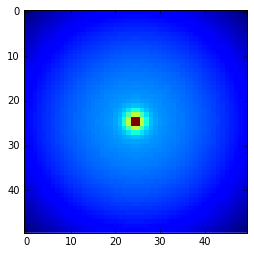

In [ ]:
energies=mean_psf_cube.energies(mode="edges")
print("PSF image in the energy band: "+str("%.2f"%energies[3].value)+"-"+str("%.2f"%energies[4].value)+" TeV")
plt.figure()
plt.imshow(mean_psf_cube.data[3,:,:],interpolation='None')

## Make the cube analysis assuming a true energy different than the reconstructed energy

In [ ]:
#Load data
data_store = DataStore.from_dir(dataset_directory)

#Define the Cubes in reco and true energies
ereco = [Energy(0.5, "TeV"), Energy(40, "TeV"), 5]
etrue = [Energy(0.1, "TeV"), Energy(100, "TeV"), 20]
center = SkyCoord(83.63, 22.01, unit='deg').galactic

ref_cube_images = make_empty_cube(image_size=50, energy=ereco, center=center)
ref_cube_exposure = make_empty_cube(image_size=50, energy=etrue, center=center, data_unit="m2 s")

# Define the Exlusion Mask
refheader = ref_cube_images.sky_image_ref.to_image_hdu().header
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')
exclusion_mask = exclusion_mask.reproject(reference=refheader)

# Pb with the load psftable for one of the run that is not implemented yet...
data_store.hdu_table.remove_row(14)
cube_maker = StackedObsCubeMaker(empty_cube_images=ref_cube_images, empty_exposure_cube=ref_cube_exposure,
                                 offset_band=offset_band, data_store=data_store, obs_table=data_store.obs_table,
                                 exclusion_mask=exclusion_mask, save_bkg_scale=True)
cube_maker.make_cubes(make_background_image=True, radius=10.)
obslist = [data_store.obs(id) for id in data_store.obs_table["OBS_ID"]]
ObsList = ObservationList(obslist)

#The PSF cube is now calculated in true energie
mean_psf_cube = make_mean_psf_cube(image_size=50, energy_cube=etrue, center_maps=center, center=center,
                                   ObsList=ObsList,
                                   spectral_index=2.3)


filename_mask = 'exclusion_mask.fits'
filename_counts = 'counts_cube.fits'
filename_bkg = 'bkg_cube.fits'
filename_significance = 'significance_cube.fits'
filename_excess = 'excess_cube.fits'
filename_exposure = 'exposure_cube_etrue.fits'
filename_psf = 'psf_cube_etrue.fits'
exclusion_mask.write(filename_mask, clobber=True)
cube_maker.counts_cube.write(filename_counts, format="fermi-counts", clobber=True)
cube_maker.bkg_cube.write(filename_bkg, format="fermi-counts", clobber=True)
cube_maker.significance_cube.write(filename_significance, format="fermi-counts", clobber=True)
cube_maker.excess_cube.write(filename_excess, format="fermi-counts", clobber=True)
cube_maker.exposure_cube.write(filename_exposure, format="fermi-counts", clobber=True)
mean_psf_cube.write(filename_psf, format="fermi-counts", clobber=True)



In [ ]:
counts_energies=cube_maker.counts_cube.energies(mode="edges")
print("the bin edges of the count cubes ", counts_energies)
print("")
true_energies=cube_maker.exposure_cube.energies(mode="edges")
print("the bin edges of the exposure cubes ", true_energies)
print("")

### Define a method to compute the mean rmf from a set of observation

In [ ]:
def make_mean_rmf(energy_true, energy_reco, center, ObsList):
    """
    Compute the mean psf for a set of observation and a given energy band
    Parameters
    ----------
    energy_true: Tuple for the energy axis: (Emin,Emax,nbins)
         for the true energy array
    energy_reco: Tuple for the energy axis: (Emin,Emax,nbins)   
         for the reco energy array
    source_name: name of the source you want to compute the image
    center: SkyCoord of the source
    ObsList: ObservationList to use to compute the psf (could be different that the data_store for G0p9 for the GC for example)


    Returns
    -------
    rmf: `~gammapy.irf.EnergyDispersion`
        Stacked EDISP for a set of observation
    """

    # Here all the observations have a center at less than 2 degrees from the Crab so it will be ok to estimate the mean psf on the Crab source postion (the area is define for offset equal to 2 degrees...)
    emin_true, emax_true, nbin_true = energy_true
    emin_reco, emax_reco, nbin_reco = energy_reco
    energy_true_bins = EnergyBounds.equal_log_spacing(emin_true, emax_true, nbin_true, 'TeV')
    energy_reco_bins = EnergyBounds.equal_log_spacing(emin_reco, emax_reco, nbin_reco, 'TeV')
    rmf = ObsList.make_mean_edisp(position=center, e_true=energy_true_bins, e_reco=energy_reco_bins)
    return rmf



In [ ]:
mean_rmf = make_mean_rmf(energy_true=etrue, energy_reco=ereco, center=center, ObsList=ObsList)
filename_rmf = 'rmf.fits'
mean_rmf.write(filename_rmf, clobber=True)
